In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from data_reconstruct import *
from data_reconstruct.backend import *
from data_reconstruct.examples import *
from data_reconstruct.utilities import *

In [3]:
random_state = 42
np.random.seed(random_state)

# Load Data

In [4]:
# Read
mod1 = pd.read_excel('data/SAIPE.xls')
mod1.columns = mod1.iloc[0]
mod1 = mod1[1:]
mod2 = pd.read_csv('data/public_150k_plus_210630.csv')
mod1_tagged = process_saipe(mod1)
mod2_tagged = process_ppp(mod2)
mod1, mod1_cols, mod1_tags_cols = mod1_tagged
mod2, mod2_cols, mod2_tags_cols = mod2_tagged

# Merge
mod1, mod2, annotations = merge_data(mod1_tagged, mod2_tagged, agg_by_tag=True)

# Sample
num_samples = min(mod1.shape[0], 2000)
mod1_sample = mod1.sample(num_samples, random_state=random_state)
mod2_sample = mod2.sample(num_samples, random_state=random_state)
annotations_sample = annotations.sample(num_samples, random_state=random_state);

# Predict Excluded Records

In [5]:
predicted_feature = 3

split_idx = int(.8 * len(mod2_sample))
pipeline_output = run_pipeline(
    mod1_sample.to_numpy(),
    mod2_sample.to_numpy(),
    train_idx=split_idx,
    output_cols=[predicted_feature],
    # std_function_and_inv=(lambda x: x**3, lambda x: x**(1/3)),
    embedding_dim=50,
    embedding_kwargs={
        'project_mode': 'tsne',
        'epoch_pd': 2000,
        'log_pd': 200,
        'epoch_DNN': 100,
        'log_DNN': 20,
    },
    hidden_dim=50,
    nn_kwargs={
        'epochs': 200,
        'log_epoch': 20,
        # 'criterion': torch.nn.L1Loss(),
        # 'optimizer': lambda x: torch.optim.AdamW(x, lr=1e-6),
    },
)

use random seed: 666
Shape of Raw data
Dataset 0: (541, 19)
Dataset 1: (432, 9)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[200/2000] err:0.2645 alpha:0.4565
epoch:[400/2000] err:0.2533 alpha:0.4393
epoch:[600/2000] err:0.2723 alpha:0.4762
epoch:[800/2000] err:0.2873 alpha:0.5081
epoch:[1000/2000] err:0.2987 alpha:0.5354
epoch:[1200/2000] err:0.3069 alpha:0.5590
epoch:[1400/2000] err:0.3123 alpha:0.5793
epoch:[1600/2000] err:0.3154 alpha:0.5969
epoch:[1800/2000] err:0.3165 alpha:0.6124
epoch:[2000/2000] err:0.3161 alpha:0.6259
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[20/100]: loss:2.271123, align_loss:0.267150
epoch:[40/100]: loss:2.170308, align_loss:0.273776
epoch:[60/100]: loss:2.213142, align_loss:0.275120
epoch:[80/100]: loss:2.113813, align_loss:0.265835
epoch:[100/100]: loss:1.804664, align_loss:0.267520
Done
---------------------------------
unionCom Done!
time: 

# Evaluate Results

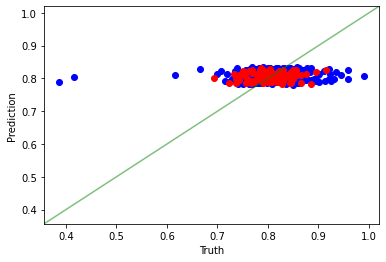

In [6]:
plot_example_results(mod2_sample.iloc[:, predicted_feature], pipeline_output, split_idx)